In [3]:
from google.cloud import vision
from pdf2image import convert_from_path
from PIL import Image, ImageDraw, ImageFont
import io
import fitz  # PyMuPDF
import os
from xml.sax.saxutils import escape


In [4]:
client = vision.ImageAnnotatorClient()

I0000 00:00:1732228958.675713 2534383 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [ ]:
def build_processed_pdf(directory, filename):
    annotated_images = []
    unannotated_images = []  # Unannotated images
    text_pages = []
    word_locations_list = []

    file_path = os.path.join(directory, filename)
    print(f"beginning to process: {file_path}")

    # Load PDF and extract image bytes from a given page
    doc = fitz.open(file_path)

    for page_num in range(doc.page_count):
        print(f"processing page: {page_num}...")
        
        page = doc.load_page(page_num)  # Load the first page
        images = page.get_images(full=True)
        xref = images[0][0]  # Get the first image reference
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]  # Get the raw JPEG byte content

        # Convert to PIL Image for further processing if needed
        pil_image = Image.open(io.BytesIO(image_bytes))
        
        # Save unannotated image before drawing
        unannotated_images.append(pil_image.copy())

        # Annotate with vision
        image = vision.Image(content=image_bytes)
        response = client.text_detection(image=image)
        text_annotations = response.text_annotations

        # Build labeled image
        font_size = 15  
        font_path="/System/Library/Fonts/Supplemental/Arial.ttf"
        font = ImageFont.truetype(font_path, font_size)

        draw = ImageDraw.Draw(pil_image)
        for i, text_obj in enumerate(text_annotations):
            # Get the bounding box vertices
            vertices = [(vertex.x, vertex.y) for vertex in text_obj.bounding_poly.vertices]

            # Draw a polygon based on the bounding box
            if len(vertices) == 4:
                draw.polygon(vertices, outline="red", width=2)
                if i > 0: # first bounding box is whole text region
                    draw.text(vertices[0], text_obj.description, fill="red", font=font)

        full_page_text = text_annotations[0].description  # always the first text_annotation object
        word_locations = text_annotations[1:]
        word_locations_list.append(word_locations)
        text_pages.append(full_page_text)


    return text_pages, word_locations_list, annotated_images

In [6]:
import os
import json

def save_annotated_text_and_image_data(root_dir, data_location, text_data, image_data):
    """
    Creates a directory structure to save images, text data, and an HTML gallery for viewing.
    
    Parameters:
        root_dir (str): The root directory to store data.
        data_location (str): Directory location under root_dir for storing files.
        text_data (list of str): List of extracted text for each page.
        image_data (list of tuples): List of tuples, where each tuple contains the image filename (str) 
                                     and the image data (as bytes or PIL image).
                                     
    """
    # Create directory paths
    base_dir = os.path.join(root_dir, data_location)
    os.makedirs(base_dir, exist_ok=True)

    images_dir = os.path.join(base_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    
    # File paths for JSONL and HTML files
    jsonl_file_path = os.path.join(base_dir, "extracted_text.jsonl")
    html_file_path = os.path.join(base_dir, "index.html")
    
    # Step 1: Save text data to JSONL
    with open(jsonl_file_path, "w", encoding="utf-8") as jsonl_file:
        for i, text in enumerate(text_data):
            entry = {
                "image": f"images/page{i+1}.jpg",  # Image filename
                "text": text
            }
            jsonl_file.write(json.dumps(entry) + "\n")
    
    # Step 2: Save images to the images directory
    for i, img in enumerate(image_data):
        image_path = os.path.join(images_dir, f"page{i+1}.jpg")
        img.save(image_path, format="JPEG")
    
    # Step 3: Generate HTML file for viewing
    with open(html_file_path, "w", encoding="utf-8") as html_file:
        html_file.write("<html><head><title>Annotated Image Gallery</title></head><body>\n")
        html_file.write("<h1>Annotated Image Gallery</h1>\n")
        
        for i, text in enumerate(text_data):
            img_filename = f"images/page{i+1}.jpg"
            html_file.write("<div class='image-entry'>\n")
            html_file.write(f"  <img src='{img_filename}' alt='Page {i+1}' style='width:100%; max-width:600px;'>\n")
            html_file.write(f"  <textarea readonly style='width:100%; height:150px;'>{text}</textarea>\n")
            html_file.write("</div><br>\n")
        
        html_file.write("</body></html>")

    print(f"Data successfully saved in {base_dir}")

# Example usage:
# save_annotated_text_and_image_data(root_dir="my_data", data_location="ocr_project", text_data=["text1", "text2"], image_data=[("img1.jpg", img_bytes), ("img2.jpg", img_bytes)])

In [7]:
import os

def save_xml_text_file(root_dir, title_file, text_data):
    """
    Generates and saves an XML file with a title and pages, where each page contains text data.
    
    Parameters:
        root_dir (str): The root directory where the XML file will be saved.
        title_file (str): The title to be used in the XML file and filename.
        text_data (list of str): List of extracted text for each page.
    """
    # Define the XML file path
    xml_file_path = os.path.join(root_dir, title_file, f"full_OCR_text_{title_file}.xml")
    os.makedirs(os.path.dirname(xml_file_path), exist_ok=True)
    
    # Start writing the XML file
    with open(xml_file_path, "w", encoding="utf-8") as xml_file:
        # Write XML declaration and root element with title
        xml_file.write("<?xml version='1.0' encoding='UTF-8'?>\n")
        xml_file.write(f"<document>\n  <title>{escape(title_file)}</title>\n")
        
        # Add each page with its content, escaping the text for XML safety
        for i, text in enumerate(text_data):
            # Escape text content to handle special characters
            escaped_text = escape(text)
            # Write each page as <page page="1">...</page>
            xml_file.write(f"  <page page='{i+1}'>\n")
            xml_file.write(f"    {escaped_text}\n")
            xml_file.write("  </page>\n")
        
        # Close the root element
        xml_file.write("</document>")

    print(f"XML file successfully saved at {xml_file_path}")

In [8]:
def full_pdf_process(pdf_dir, pdf_filename, output_dir):
    current_title, ext = os.path.splitext(pdf_filename)
    assert ext == ".pdf", f"Expected .pdf, got {ext}"
    text_pages, marked_images = build_processed_pdf(pdf_dir, pdf_filename)
    save_annotated_text_and_image_data(output_dir, current_title, text_pages, marked_images)
    save_xml_text_file(output_dir, current_title, text_pages)
    return text_pages, marked_images

In [9]:
# directory to read pdfs from
pdf_dir = "../PDF/Phat_Giao_journals"

# directory to save output
output_dir = "../processed_journal_data"

In [10]:
text, words, images = build_processed_pdf(pdf_dir, "phat-giao-viet-nam-1956-01.pdf")

beginning to process: ../PDF/Phat_Giao_journals/phat-giao-viet-nam-1956-01.pdf
processing page: 0...
processing page: 1...
processing page: 2...
processing page: 3...
processing page: 4...
processing page: 5...
processing page: 6...
processing page: 7...
processing page: 8...
processing page: 9...
processing page: 10...
processing page: 11...
processing page: 12...
processing page: 13...
processing page: 14...
processing page: 15...
processing page: 16...
processing page: 17...
processing page: 18...
processing page: 19...
processing page: 20...
processing page: 21...
processing page: 22...
processing page: 23...
processing page: 24...
processing page: 25...
processing page: 26...
processing page: 27...
processing page: 28...
processing page: 29...
processing page: 30...
processing page: 31...
processing page: 32...
processing page: 33...
processing page: 34...
processing page: 35...
processing page: 36...
processing page: 37...
processing page: 38...
processing page: 39...
processing 

In [11]:
images[0].size

(1024, 1536)

In [12]:
words[0][0]

description: "PHẬT"
bounding_poly {
  vertices {
    x: 132
    y: 124
  }
  vertices {
    x: 552
    y: 124
  }
  vertices {
    x: 552
    y: 308
  }
  vertices {
    x: 132
    y: 308
  }
}

In [22]:
type(words[0][0])

EntityAnnotation

In [13]:
text[3]

'Dở lại những trang sử vẻ vang của dân tộc, ta thấy người\nViệt luôn luôn có ý-nguyện tạo thành một nền văn - hóa độc lập\nđề đổi chọi lại với sự đe dọa đàn áp của Bắc phương. Trong\ncông việc kiến thiết nền văn hóa độc lập ấy, Phật - Giáo Việt\nNam đã là một lực lượng quan trọng. Lịch-sử Phật - Giáo Việt-\nNam trong các triều Đinh, Lê, Lý, Trần đã chứng tỏ điều ấy.\nQuả thực Phật - Giáo Việt-Nam đã là một nền Phật-Giáo dân-tộc.\nTính Anh, tư-tưởng, lập quán và di truyền của dân tộc Việt-Nam\ncó thể không thích hợp với nhiều tôn-giáo khác, nhưng đã rất thích\nhợp với Đạo Phật. Sự thích hợp đó được chứng minh ở mọi hình\nthức.\nMột ngôi chùa thờ Phật, một tiếng chuông nhẹ rơi, một thời\nkinh trầm trầm theo tiếng mõ... cho đến những quan niệm nhân sinh\nvũ trụ đều thích hợp với cá tính dân tộc ta. Một nhà văn đã nói :\n« Tâm hồn chúng ta như đã sẵn sàng để dâng cho Đức Phật. Cái\ngì dính dáng đến Phật-Giáo đều có thể làm chúng ta rung động »\nNgười dẫn Việt Nam dù có không học giáo lý đi

In [14]:
def convert_page_words(word_info):
    
    converted_info = []
    for word in word_info:
        text = word.description
        x = [vertex.x for vertex in word.bounding_poly.vertices]
        y = [vertex.y for vertex in word.bounding_poly.vertices]
        assert len(x) == 4, "not four pointed bounding box."

        width_bottom = x[1] - x[0] # point order is: bottom-left, bottom-right, top-right, top-left
        width_top = x[2] - x[3]
        height_left = y[3] - y[0]
        height_right = y[2] - y[1] # this according to the layout of bounding poly

        if width_bottom != width_top:
            print(f"Warning bounding box width mismatch for: {text}, skipping.")
            continue
        if height_left != height_right:
            print(f"Warning bounding box height mismatch for: {text}, skipping.")
            continue
        
        new_info = [text, (x[0], y[0]), width_bottom, height_left]
        converted_info.append(new_info)
    
    return converted_info

In [15]:
new_info = convert_page_words(words[3])

Warning bounding box width mismatch for: DICH, skipping.
Warning bounding box width mismatch for: THE, skipping.
Warning bounding box height mismatch for: HAN, skipping.


In [16]:
new_info

[['Dở', (176, 110), 36, 28],
 ['lại', (226, 110), 28, 28],
 ['những', (275, 110), 66, 28],
 ['trang', (365, 110), 57, 29],
 ['sử', (438, 111), 26, 28],
 ['vẻ', (482, 111), 21, 28],
 ['vang', (515, 111), 49, 28],
 ['của', (577, 112), 35, 28],
 ['dân', (632, 112), 38, 28],
 ['tộc', (686, 112), 28, 28],
 [',', (716, 112), 4, 28],
 ['ta', (744, 112), 19, 28],
 ['thấy', (783, 113), 44, 28],
 ['người', (847, 113), 60, 28],
 ['Việt', (125, 140), 47, 28],
 ['luôn', (184, 140), 46, 28],
 ['luôn', (250, 140), 45, 28],
 ['có', (312, 140), 22, 28],
 ['ý', (353, 141), 10, 28],
 ['-', (365, 141), 9, 28],
 ['nguyện', (379, 141), 73, 28],
 ['tạo', (472, 141), 30, 28],
 ['thành', (525, 142), 57, 28],
 ['một', (600, 142), 35, 28],
 ['nền', (656, 142), 33, 28],
 ['văn', (712, 142), 36, 29],
 ['-', (760, 143), 7, 28],
 ['hóa', (778, 143), 38, 28],
 ['độc', (832, 143), 34, 28],
 ['lập', (875, 143), 30, 28],
 ['đề', (124, 171), 27, 27],
 ['đổi', (170, 171), 36, 27],
 ['chọi', (217, 171), 43, 27],
 ['lại', (

In [17]:
def collate_lines(words):
    """
    Collate OCR words into lines based on y-coordinates and line height, 
    assuming the words are already sorted by their y-coordinates.

    Args:
        words (list): List of words with their positions and dimensions 
                      in the form [text, (x, y), width, height].
    
    Returns:
        list: Collated lines in the form 
              [text_line, (start_x, start_y), (end_x, start_y), line_height].
    """
    if not words:
        return []
    
    # Sort words by y-coordinate (descending for top-to-bottom layout)
    # words = sorted(words, key=lambda w: (w[1][1], w[1][0]))
        
    collated_lines = []
    current_line = []
    current_y = words[0][1][1]
    current_height = words[0][3]

    for word in words:
        text, (x, y), width, height = word
        # Calculate tolerance for y-coordinate based on current line height
        tolerance = current_height * 0.75
        
        # Check if the word fits in the current line
        if abs(y - current_y) <= tolerance:
            current_line.append(word)
        else:
            # Finalize the current line
            if current_line:
                line_text = " ".join(w[0] for w in current_line)
                start_x = current_line[0][1][0]
                start_y = current_line[0][1][1]
                end_x = current_line[-1][1][0] + current_line[-1][2]
                collated_lines.append([line_text, (start_x, start_y), (end_x, start_y), current_height])
            
            # Start a new line
            current_line = [word]
            current_y = y
            current_height = height
    
    # Add the last line
    if current_line:
        line_text = " ".join(w[0] for w in current_line)
        start_x = current_line[0][1][0]
        start_y = current_line[0][1][1]
        end_x = current_line[-1][1][0] + current_line[-1][2]
        collated_lines.append([line_text, (start_x, start_y), (end_x, start_y), current_height])
    
    return collated_lines

In [18]:
collate_lines(new_info)

[['Dở lại những trang sử vẻ vang của dân tộc , ta thấy người',
  (176, 110),
  (907, 110),
  28],
 ['Việt luôn luôn có ý - nguyện tạo thành một nền văn - hóa độc lập',
  (125, 140),
  (905, 140),
  28],
 ['đề đổi chọi lại với sự đe dọa đàn áp của Bắc phương . Trong',
  (124, 171),
  (907, 171),
  27],
 ['công việc kiến thiết nền văn hóa độc lập ấy , Phật - Giáo Việt',
  (124, 203),
  (896, 203),
  29],
 ['Nam đã là một lực lượng quan trọng . Lịch - sử Phật - Giáo Việt-',
  (125, 234),
  (907, 234),
  30],
 ['Nam trong các triều Đinh , Lê , Lý , Trần đã chứng tỏ điều ấy .',
  (126, 267),
  (905, 267),
  25],
 ['Quả thực Phật - Giáo Việt - Nam đã là một nền Phật - Giáo dân - tộc .',
  (127, 298),
  (905, 298),
  24],
 ['Tính Anh , tư - tưởng , lập quán và di truyền của dân tộc Việt - Nam',
  (180, 344),
  (908, 344),
  25],
 ['có thể không thích hợp với nhiều tôn - giáo khác , nhưng đã rất thích',
  (127, 376),
  (907, 376),
  24],
 ['hợp với Đạo Phật . Sự thích hợp đó được chứng minh ở 

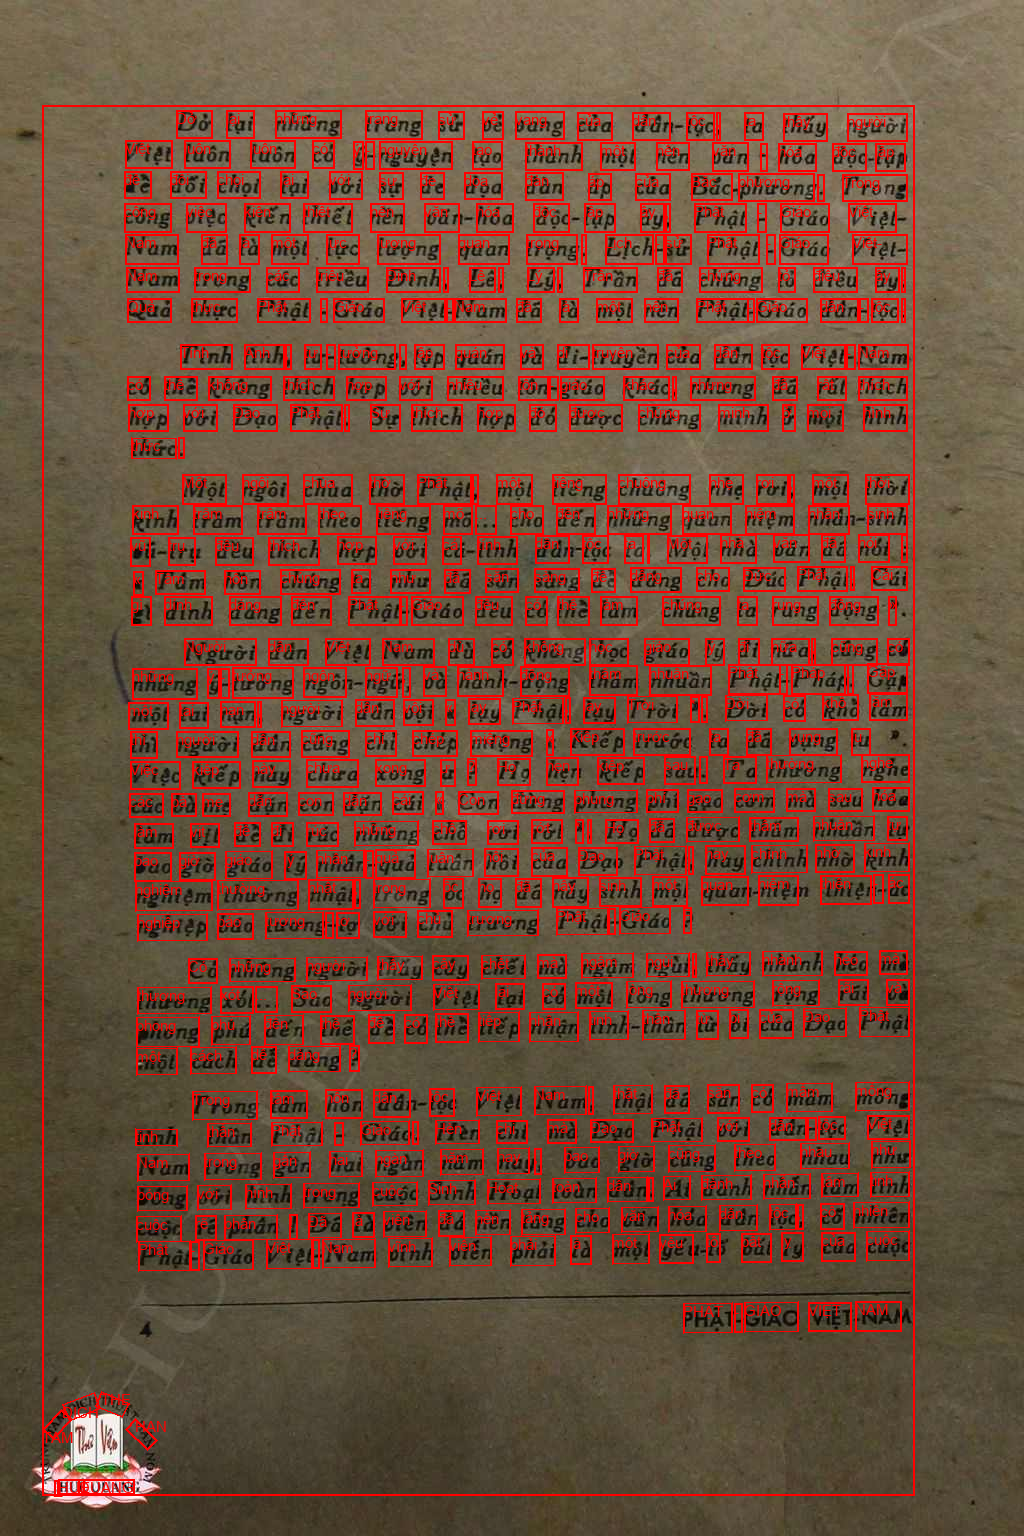

In [19]:
images[3]

In [38]:
new_info

[['PHẬT', (132, 124), 184, 420],
 ['GIÁO', (568, 124), 184, 344],
 ['VET', (124, 356), 120, 365],
 ['-', (501, 356), 120, 54],
 ['NAM', (574, 356), 120, 346],
 ['NGUYỆT', (385, 603), 48, 179],
 ['-', (566, 603), 48, 11],
 ['SÂN', (581, 603), 48, 82],
 ['SỐ', (132, 1390), 36, 42],
 ['1', (203, 1390), 36, 11],
 ['RA', (245, 1390), 36, 38],
 ['NGÀY', (310, 1390), 36, 96],
 ['15', (435, 1390), 36, 43],
 ['THÁNG', (505, 1390), 36, 116],
 ['8', (648, 1390), 36, 17],
 ['BÍNH', (693, 1390), 36, 80],
 ['THÂN', (803, 1390), 36, 83],
 ['CH', (904, 1390), 36, 44],
 ['TỔNG', (110, 1450), 45, 87],
 ['.', (210, 1450), 45, 7],
 ['HỘI', (231, 1450), 45, 53],
 ['PHẬT', (318, 1450), 45, 79],
 ['-', (402, 1450), 45, 13],
 ['GIÁO', (428, 1450), 45, 73],
 ['VIỆT', (539, 1450), 45, 61],
 ['-', (611, 1450), 45, 6],
 ['NAM', (631, 1450), 45, 73],
 ['XUẤT', (732, 1450), 45, 82],
 ['.', (820, 1450), 45, 12],
 ['The', (903, 1420), 30, 26],
 ['V', (928, 1420), 30, 19],
 ['HUỆ', (886, 1479), 15, 35],
 ['QUANG', (92

In [22]:
text_pages, marked_images = full_pdf_process(pdf_dir, "phat-giao-viet-nam-1956-25-26.pdf", output_dir)

beginning to process: ../PDF/Phat_Giao_journals/phat-giao-viet-nam-1956-25-26.pdf
processing page: 0...
processing page: 1...
processing page: 2...
processing page: 3...
processing page: 4...
processing page: 5...
processing page: 6...
processing page: 7...
processing page: 8...
processing page: 9...
processing page: 10...
processing page: 11...
processing page: 12...
processing page: 13...
processing page: 14...
processing page: 15...
processing page: 16...
processing page: 17...
processing page: 18...
processing page: 19...
processing page: 20...
processing page: 21...
processing page: 22...
processing page: 23...
processing page: 24...
processing page: 25...
processing page: 26...
processing page: 27...
Data successfully saved in ../processed_journal_data/phat-giao-viet-nam-1956-25-26
XML file successfully saved at ../processed_journal_data/phat-giao-viet-nam-1956-25-26/full_OCR_text_phat-giao-viet-nam-1956-25-26.xml


In [38]:
all_files =  os.listdir(pdf_dir)

In [42]:
all_files

['phat-giao-viet-nam-1956-15.pdf',
 'phat-giao-viet-nam-1956-01.pdf',
 'phat-giao-viet-nam-1956-28.pdf',
 'phat-giao-viet-nam-1956-14.pdf',
 'phat-giao-viet-nam-1956-02.pdf',
 'phat-giao-viet-nam-1956-16.pdf',
 'phat-giao-viet-nam-1956-20-21.pdf',
 'phat-giao-viet-nam-1956-03.pdf',
 'phat-giao-viet-nam-1956-07.pdf',
 'phat-giao-viet-nam-1956-13.pdf',
 'phat-giao-viet-nam-1956-12.pdf',
 'phat-giao-viet-nam-1956-04.pdf',
 'phat-giao-viet-nam-1956-11.pdf',
 'phat-giao-viet-nam-1956-05-06.pdf',
 'phat-giao-viet-nam-1956-09-10.pdf',
 'phat-giao-viet-nam-1956-17-18.pdf',
 'phat-giao-viet-nam-1956-25-26.pdf',
 'phat-giao-viet-nam-1956-23.pdf',
 'phat-giao-viet-nam-1956-22.pdf',
 'phat-giao-viet-nam-1956-27.pdf',
 'phat-giao-viet-nam-1956-19.pdf',
 'phat-giao-viet-nam-1956-24.pdf']

In [43]:
px_list = [all_files[2]] + all_files[6:16] + all_files[17:21]

In [44]:
px_list

['phat-giao-viet-nam-1956-28.pdf',
 'phat-giao-viet-nam-1956-20-21.pdf',
 'phat-giao-viet-nam-1956-03.pdf',
 'phat-giao-viet-nam-1956-07.pdf',
 'phat-giao-viet-nam-1956-13.pdf',
 'phat-giao-viet-nam-1956-12.pdf',
 'phat-giao-viet-nam-1956-04.pdf',
 'phat-giao-viet-nam-1956-11.pdf',
 'phat-giao-viet-nam-1956-05-06.pdf',
 'phat-giao-viet-nam-1956-09-10.pdf',
 'phat-giao-viet-nam-1956-17-18.pdf',
 'phat-giao-viet-nam-1956-23.pdf',
 'phat-giao-viet-nam-1956-22.pdf',
 'phat-giao-viet-nam-1956-27.pdf',
 'phat-giao-viet-nam-1956-19.pdf']

In [45]:
for filename in px_list:
        #print(filename)  # Do something with each file path
        full_pdf_process(pdf_dir, filename, output_dir)

beginning to process: ../PDF/Phat_Giao_journals/phat-giao-viet-nam-1956-28.pdf
processing page: 0...
processing page: 1...
processing page: 2...
processing page: 3...
processing page: 4...
processing page: 5...
processing page: 6...
processing page: 7...
processing page: 8...
processing page: 9...
processing page: 10...
processing page: 11...
processing page: 12...
processing page: 13...
processing page: 14...
processing page: 15...
processing page: 16...
processing page: 17...
processing page: 18...
processing page: 19...
processing page: 20...
processing page: 21...
processing page: 22...
processing page: 23...
processing page: 24...
processing page: 25...
processing page: 26...
processing page: 27...
processing page: 28...
processing page: 29...
processing page: 30...
processing page: 31...
processing page: 32...
processing page: 33...
processing page: 34...
processing page: 35...
processing page: 36...
processing page: 37...
processing page: 38...
processing page: 39...
processing 